In [1]:
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import random
import string
import networkx as nx
import logging

# --- Setup and Configuration ---
# Suppress verbose logging for a cleaner output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6 # The specific layer we are interested in

# --- Helper Functions (adapted from the second script) ---


def build_positions_3x3(node_names):
    """Builds a dictionary mapping node names to (row, col) coordinates."""
    return {node_names[i]: (i // 3, i % 3) for i in range(len(node_names))}

def generate_long_random_walk(G, walk_length=50):
    """Generates a random walk of a given length on the graph."""
    nodes = list(G.nodes)
    current_node = random.choice(nodes)
    walk = [current_node]
    while len(walk) < walk_length:
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk

def walk_to_string(walk, G):
    """Converts a walk path into a string prompt."""
    tokens = []
    for i in range(len(walk) - 1):
        node1, node2 = walk[i], walk[i+1]
        direction = G.edges[(node1, node2)]['direction']
        tokens.extend([node1, direction])
    tokens.append(walk[-1])
    return " ".join(tokens)

class GPTLayerWrapper:
    """A wrapper to handle model loading and hidden state extraction for a specific layer."""
    def __init__(self, model_path, local_files_only=False):
        logging.info(f"Loading model: {model_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True, local_files_only=local_files_only).to(DEVICE)
        self.model.eval()

    def get_layer_representation(self, prompt, layer):
        """Gets the representation for a prompt from a single layer."""
        tokens = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = self.model(**tokens)
            # We take the mean of all token representations in the specified layer
            return torch.mean(outputs.hidden_states[layer][0], dim=0).cpu().numpy()

    def get_node_embeddings_from_layer(self, prompt, node_names, layer):
        """Extracts average embeddings for a list of node names from a specific layer."""
        enc = self.tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, truncation=True)
        offsets = enc.pop("offset_mapping")[0].tolist()
        
        with torch.no_grad():
            outputs = self.model(**enc.to(DEVICE))
            hidden_states = outputs.hidden_states[layer].squeeze(0).cpu().numpy()

        loc_means = {}
        for loc in node_names:
            found_vecs = []
            start = 0
            while True:
                idx = prompt.find(loc, start)
                if idx == -1: break
                span_start, span_end = idx, idx + len(loc)
                start = idx + 1
                
                # Gather embeddings for the span
                overlap_vecs = [hidden_states[i] for i, (s, e) in enumerate(offsets) if not (e <= span_start or s >= span_end)]
                if overlap_vecs:
                    found_vecs.append(np.mean(overlap_vecs, axis=0))
            
            if found_vecs:
                loc_means[loc] = np.mean(found_vecs, axis=0)
        return loc_means

def calc_pearson_correlation(node_names, loc_mean_repr, positions):
    """Calculates Pearson correlation between representational and grid distances."""
    recognized = [n for n in node_names if n in loc_mean_repr]
    if len(recognized) < 3: return float('nan')

    man_distances, rep_distances = [], []
    for i in range(len(recognized)):
        for j in range(i + 1, len(recognized)):
            u, v = recognized[i], recognized[j]
            r1, c1 = positions[u]
            r2, c2 = positions[v]
            man_dist = abs(r1 - r2) + abs(c1 - c2)
            rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
            man_distances.append(man_dist)
            rep_distances.append(rep_dist)
    
    if len(man_distances) < 2: return float('nan')
    return pearsonr(man_distances, rep_distances)[0]



/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
# # Experiment 1: Hidden State Drift Over Training (Layer 6)

# logging.info("--- Starting Experiment 1: Hidden State Drift over Training ---")
# query_prompt = "MODE: Shortest, START: apple, END: orange, PATH: apple R banana D grape"
# reps_over_training_layer6 = []

# for step in CHECKPOINT_STEPS:
#     model_path = MODEL_BASE_PATH.format(step)
#     wrapper = GPTLayerWrapper(model_path, local_files_only=True)
#     rep = wrapper.get_layer_representation(query_prompt, layer=LAYER_IDX)
#     reps_over_training_layer6.append(rep)
#     del wrapper, rep
#     torch.cuda.empty_cache()

# # Calculate similarity to the initial checkpoint
# initial_rep = reps_over_training_layer6[0].reshape(1, -1)
# similarities = [cosine_similarity(initial_rep, rep.reshape(1, -1))[0, 0] for rep in reps_over_training_layer6]

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(CHECKPOINT_STEPS, similarities, marker='o', linestyle='-', color='b')
# plt.title(f'Hidden State Drift in Layer {LAYER_IDX} Over Training\n(Cosine Similarity to Initial Checkpoint)')
# plt.xlabel('Training Step')
# plt.ylabel('Cosine Similarity')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.ylim(min(0.8, min(similarities) - 0.05), 1.0)
# plt.tight_layout()
# plt.show()



In [3]:
from wonderwords import RandomWord

# Generalist V1 (4x4 model): Spatial Correlation vs. Context Length (Layer 6)

logging.info("--- Starting Experiment 2: Spatial Correlation vs. Context Length ---")
context_lengths = [10, 20, 30, 40,50, 60, 70, 80, 100, 150]
n_runs = 200 # Number of runs to average for each context length
avg_correlations = []

# Load the final model

path = "./all_models/generalist_v1"

def generate_name():
    """Generates a single random noun."""
    r = RandomWord()
    word = r.word(include_parts_of_speech=["nouns"])
    return word.replace(" ", "_") if word else None

def get_grid_graph_4x4(nodes=None):
    """Creates a 3x3 NetworkX grid graph."""
    if nodes is None:
        nodes = [generate_name() for _ in range(16)]
    G = nx.DiGraph()
    # Add nodes and edges with direction attributes
    for i in range(4):
        for j in range(4):
            node_idx = i * 4 + j
            if j < 3: # East-West edges
                G.add_edge(nodes[node_idx], nodes[node_idx + 1], direction='R')
                G.add_edge(nodes[node_idx + 1], nodes[node_idx], direction='L')
            if i < 3: # North-South edges
                G.add_edge(nodes[node_idx], nodes[node_idx + 4], direction='D')
                G.add_edge(nodes[node_idx + 4], nodes[node_idx], direction='U')
    return G, nodes

def build_positions_4x4(node_names):
    """Builds a dictionary mapping node names to (row, col) coordinates."""
    return {node_names[i]: (i // 4, i % 4) for i in range(len(node_names))}

final_wrapper = GPTLayerWrapper(path)

for length in context_lengths:
    run_corrs = []
    for i in range(n_runs):
        G, node_names = get_grid_graph_4x4()
        positions = build_positions_4x4(node_names)
        walk = generate_long_random_walk(G, walk_length=length)
        prompt = walk_to_string(walk, G)
        
        loc_mean_repr = final_wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        
        if not np.isnan(corr):
            run_corrs.append(corr)
    
    mean_corr = np.mean(run_corrs) if run_corrs else float('nan')
    avg_correlations.append(mean_corr)
    logging.info(f"Context length={length}, Avg. Pearson correlation={mean_corr:.4f} (from {len(run_corrs)} runs)")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(context_lengths, avg_correlations, marker='s', linestyle='--', color='r')
plt.title(f'Spatial Correlation in Layer {LAYER_IDX} vs. Context Length\n(Generalist V1 Model)')
plt.xlabel('Random Walk Length (Context Size)')
plt.ylabel('Average Pearson Correlation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


2025-07-23 14:22:11,844 - INFO - --- Starting Experiment 2: Spatial Correlation vs. Context Length ---
2025-07-23 14:22:11,846 - INFO - Loading model: ./all_models/generalist_v1
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-23 14:22:36,620 - INFO - Context length=10, Avg. Pearson correlation=0.6287 (from 200 runs)


KeyboardInterrupt: 

2025-07-22 10:48:02,968 - INFO - --- Starting Experiment 2: Spatial Correlation vs. Context Length ---
2025-07-22 10:48:02,971 - INFO - Loading model: ./all_models/ellie


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-22 10:48:29,728 - INFO - Context length=10, Avg. Pearson correlation=0.5608 (from 299 runs)
2025-07-22 10:48:33,727 - INFO - Context length=20, Avg. Pearson correlation=0.6731 (from 300 runs)
2025-07-22 10:48:37,916 - INFO - Context length=30, Avg. Pearson correlation=0.7296 (from 300 runs)
2025-07-22 10:48:42,238 - INFO - Context length=40, Avg. Pearson correlation=0.7693 (from 300 runs)
2025-07-22 10:48:46,742 - IN

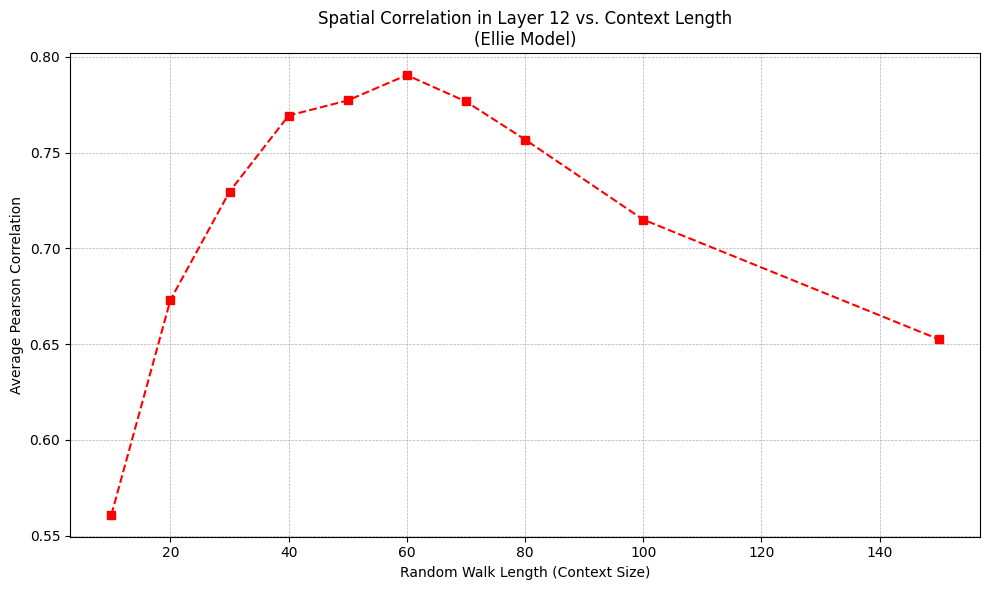

In [ ]:
# Ellie: Spatial Correlation vs. Context Length (Layer 6)

logging.info("--- Starting Experiment 2: Spatial Correlation vs. Context Length ---")
context_lengths = [10, 20, 30, 40,50, 60,70, 80, 100, 150]
n_runs = 300 # Number of runs to average for each context length
avg_correlations = []


path = "./all_models/ellie"

# model specific helper functions
def generate_name(k=2):
    """Generates a short, random name for a node."""
    return ''.join(random.choices(string.ascii_lowercase, k=k))
def get_grid_graph_3x3():
    nodes=[generate_name() for _ in range(9)]; G=nx.DiGraph(); size=3
    for r in range(size):
        for c in range(size):
            idx=r*size+c
            if c<size-1: G.add_edge(nodes[idx],nodes[idx+1],direction='EAST')
            if c>0: G.add_edge(nodes[idx],nodes[idx-1],direction='WEST')
            if r<size-1: G.add_edge(nodes[idx],nodes[idx+size],direction='SOUTH')
            if r>0: G.add_edge(nodes[idx],nodes[idx-size],direction='NORTH')
    return G, nodes

final_wrapper = GPTLayerWrapper(path)
LAYER_IDX = 12  # The specific layer we are interested in
for length in context_lengths:
    run_corrs = []
    for i in range(n_runs):
        G, node_names = get_grid_graph_3x3()
        positions = build_positions_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length=length)
        prompt = walk_to_string(walk, G)
        #print(f"Run {i+1}/{n_runs}: Context length={length}, Prompt='{prompt[:50]}...'")
        
        loc_mean_repr = final_wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        
        if not np.isnan(corr):
            run_corrs.append(corr)
    
    mean_corr = np.mean(run_corrs) if run_corrs else float('nan')
    avg_correlations.append(mean_corr)
    logging.info(f"Context length={length}, Avg. Pearson correlation={mean_corr:.4f} (from {len(run_corrs)} runs)")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(context_lengths, avg_correlations, marker='s', linestyle='--', color='r')
plt.title(f'Spatial Correlation in Layer {LAYER_IDX} vs. Context Length\n(Ellie Model)')
plt.xlabel('Random Walk Length (Context Size)')
plt.ylabel('Average Pearson Correlation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


2025-07-22 10:49:18,594 - INFO - --- Starting Experiment 2: Spatial Correlation vs. Context Length ---
2025-07-22 10:49:18,595 - INFO - Loading model: ./all_models/foraging_v1
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-22 10:49:28,734 - INFO - Context length=10, Avg. Pearson correlation=0.5216 (from 300 runs)
2025-07-22 10:49:31,075 - INFO - Context length=20, Avg. Pearson correlation=0.6123 (from 300 runs)
2025-07-22 10:49:33,575 - INFO - Context length=30, 

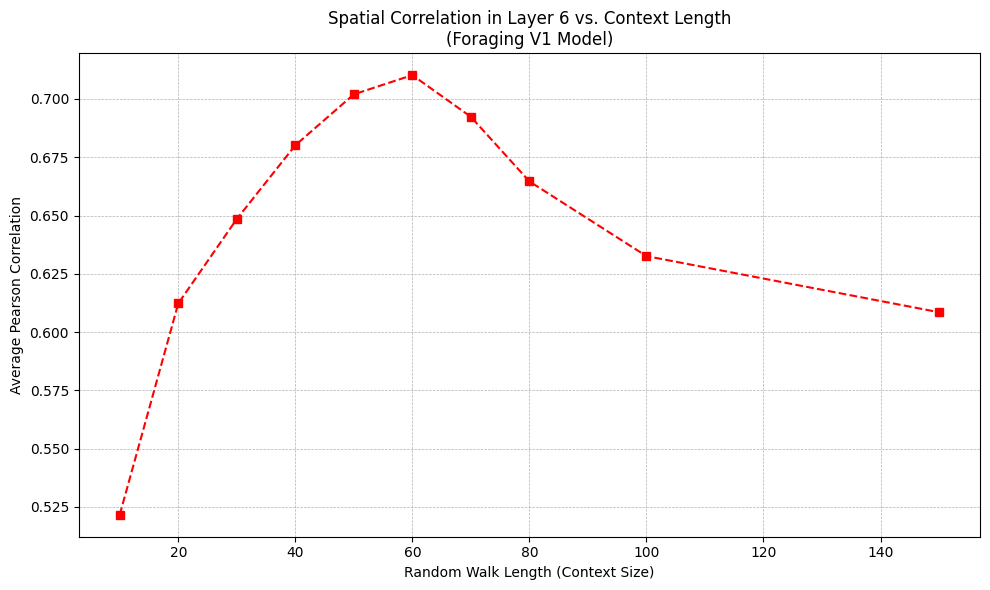

In [ ]:
# Foraging V1: Spatial Correlation vs. Context Length (Layer 6)

logging.info("--- Starting Experiment 2: Spatial Correlation vs. Context Length ---")
context_lengths = [10, 20, 30, 40,50, 60,70, 80, 100, 150]
n_runs = 300 # Number of runs to average for each context length
avg_correlations = []


path = "./all_models/foraging_v1"

# model specific helper functions
def generate_name(k=2):
    """Generates a short, random name for a node."""
    return ''.join(random.choices(string.ascii_lowercase, k=k))
def get_grid_graph_3x3():
    nodes=[generate_name() for _ in range(9)]; G=nx.DiGraph(); size=3
    for r in range(size):
        for c in range(size):
            idx=r*size+c
            if c<size-1: G.add_edge(nodes[idx],nodes[idx+1],direction='R')
            if c>0: G.add_edge(nodes[idx],nodes[idx-1],direction='L')
            if r<size-1: G.add_edge(nodes[idx],nodes[idx+size],direction='D')
            if r>0: G.add_edge(nodes[idx],nodes[idx-size],direction='U')
    return G, nodes

final_wrapper = GPTLayerWrapper(path)
LAYER_IDX = 6  # gpt small

for length in context_lengths:
    run_corrs = []
    for i in range(n_runs):
        G, node_names = get_grid_graph_3x3()
        positions = build_positions_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length=length)
        prompt = walk_to_string(walk, G)
        #print(f"Run {i+1}/{n_runs}: Context length={length}, Prompt='{prompt[:50]}...'")
        
        loc_mean_repr = final_wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        
        if not np.isnan(corr):
            run_corrs.append(corr)
    
    mean_corr = np.mean(run_corrs) if run_corrs else float('nan')
    avg_correlations.append(mean_corr)
    logging.info(f"Context length={length}, Avg. Pearson correlation={mean_corr:.4f} (from {len(run_corrs)} runs)")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(context_lengths, avg_correlations, marker='s', linestyle='--', color='r')
plt.title(f'Spatial Correlation in Layer {LAYER_IDX} vs. Context Length\n(Foraging V1 Model)')
plt.xlabel('Random Walk Length (Context Size)')
plt.ylabel('Average Pearson Correlation')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

# # --- Graph Generation (Unchanged) ---
# def get_grid_graph_3x3():
#     """Generates a standard 3x3 grid graph using networkx."""
#     G = nx.grid_2d_graph(3, 3)
#     return nx.DiGraph(G)

# def generate_long_random_walk(G, start_node, walk_length):
#     """Generates a single random walk of a given length."""
#     walk = [start_node]
#     current_node = start_node
#     for _ in range(walk_length - 1):
#         neighbors = list(G.successors(current_node))
#         if not neighbors: break
#         next_node = random.choice(neighbors)
#         walk.append(next_node)
#         current_node = next_node
#     return walk

# --- The Corrected Ideal Observer Class ---
class IdealObserver:
    """
    Simulates an observer learning a graph structure from a walk.
    Measures uncertainty using Shannon Entropy.
    """
    def __init__(self, true_graph):
        self.nodes = list(true_graph.nodes())
        self.true_edges = set(true_graph.edges())
        
        # Initialize beliefs based on prior knowledge of the grid structure.
        self.beliefs = {}
        for u in self.nodes:
            for v in self.nodes:
                if u == v: continue
                if (u, v) in self.true_edges:
                    self.beliefs[(u, v)] = 0.5
                else:
                    self.beliefs[(u, v)] = 0.0

    def shannon_entropy(self, p):
        """Calculates entropy for a single binary event."""
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        return - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

    def get_total_entropy(self):
        """Calculates the total uncertainty over all possible edges."""
        total_entropy = 0.0
        for p in self.beliefs.values():
            total_entropy += self.shannon_entropy(p)
        return total_entropy

    def observe_step(self, u, v):
        """Upon observing an edge, the observer becomes 100% certain it exists."""
        if (u, v) in self.beliefs:
            self.beliefs[(u, v)] = 1.0

# --- Simulation Logic ---
def run_information_gain_simulation(walk_length=300, n_runs=50):
    all_runs_entropy = []
    
    for run in range(n_runs):
        if run % 10 == 0:
            print(f"Running simulation {run+1}/{n_runs}...")
        
        G = get_grid_graph_3x3()
        nodes = list(G.nodes())
        start_node = random.choice(nodes)
        walk = generate_long_random_walk(G, start_node, walk_length)

        observer = IdealObserver(G)
        entropy_over_time = []
        for i in range(len(walk) - 1):
            entropy_over_time.append(observer.get_total_entropy())
            u, v = walk[i], walk[i+1]
            observer.observe_step(u, v)
        
        all_runs_entropy.append(entropy_over_time)

    max_len = max(len(run) for run in all_runs_entropy)
    padded_runs = [np.pad(run, (0, max_len - len(run)), 'edge') for run in all_runs_entropy]
    avg_entropy_curve = np.mean(padded_runs, axis=0)

    return avg_entropy_curve

# --- Run and Plot ---
if __name__ == "__main__":
    WALK_LENGTH = 300
    N_AVERAGING_RUNS = 50
    
    print("Starting Corrected Information-Theoretic Simulation...")
    avg_entropy_over_time = run_information_gain_simulation(
        walk_length=WALK_LENGTH, 
        n_runs=N_AVERAGING_RUNS
    )
    
    steps = np.arange(len(avg_entropy_over_time))

    # --- ADDED: Find the Elbow of the Curve ---
    # The elbow is the point on the curve with the maximum distance
    # to the line connecting the first and last points.
    
    # Create a line connecting the start and end points
    p1 = np.array([steps[0], avg_entropy_over_time[0]])
    p2 = np.array([steps[-1], avg_entropy_over_time[-1]])

    # Calculate the perpendicular distance of each point on the curve to the line
    line_vec = p2 - p1
    line_vec_norm = np.linalg.norm(line_vec)
    point_vecs = np.array([steps, avg_entropy_over_time]).T - p1
    
    # Use cross product to find perpendicular distances
    cross_product = np.cross(point_vecs, line_vec)
    distances = np.abs(cross_product) / line_vec_norm

    # Find the index of the point with the maximum distance
    elbow_index = np.argmax(distances)
    elbow_step = steps[elbow_index]
    
    print(f"Elbow point identified at step: {elbow_step}")
    
    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Plot the main entropy curve
    ax.plot(steps, avg_entropy_over_time, color='b')
    
    
    # Highlight your model's peak performance
    ax.axvline(x=50, color='r', linestyle='--', label='Observed Peak Correlation (x=60)', linewidth=2)
    
    # Highlight the calculated elbow point
    ax.axvline(x=elbow_step, color='g', linestyle='-.', label=f'Calculated "Elbow" (x={elbow_step})', linewidth=2)

    ax.set_title("Information Gain Over a Random Walk", fontsize=16)
    ax.set_xlabel("# Steps in Random Walk", fontsize=12)
    ax.set_ylabel("Total Shannon Entropy (System Uncertainty)", fontsize=12)
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()

Starting Corrected Information-Theoretic Simulation...
Running simulation 1/50...


AttributeError: 'tuple' object has no attribute 'nodes'

In [ ]:
set_seed(42)
import os

# Params
CWD = os.getcwd()
CHECKPOINT_STEPS = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 131511]
# MODEL_BASE_PATH = "generalist_model/checkpoint-{}"
MODEL_OUTPUT_DIR = 'generalist_model' # Use the correct output directory name

MODEL_BASE_PATH = os.path.join(CWD, MODEL_OUTPUT_DIR, 'checkpoint-{0}')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6                # The specific layer we are analyzing
WALK_LENGTH = 50             # Fixed context length for a fair comparison across checkpoints
N_RUNS = 200                  # Number of trials to average for each checkpoint to get a stable score

class GPTLayerWrapper:
    """A wrapper to handle model loading and hidden state extraction for a specific layer."""
    def __init__(self, model_path):
        logging.info(f"Loading model: {model_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(model_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True).to(DEVICE)
        self.model.eval()

    def get_layer_representation(self, prompt, layer):
        """Gets the representation for a prompt from a single layer."""
        tokens = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            outputs = self.model(**tokens)
            # We take the mean of all token representations in the specified layer
            return torch.mean(outputs.hidden_states[layer][0], dim=0).cpu().numpy()

    def get_node_embeddings_from_layer(self, prompt, node_names, layer):
        """Extracts average embeddings for a list of node names from a specific layer."""
        enc = self.tokenizer(prompt, return_tensors="pt", return_offsets_mapping=True, truncation=True)
        offsets = enc.pop("offset_mapping")[0].tolist()
        
        with torch.no_grad():
            outputs = self.model(**enc.to(DEVICE))
            hidden_states = outputs.hidden_states[layer].squeeze(0).cpu().numpy()

        loc_means = {}
        for loc in node_names:
            found_vecs = []
            start = 0
            while True:
                idx = prompt.find(loc, start)
                if idx == -1: break
                span_start, span_end = idx, idx + len(loc)
                start = idx + 1
                
                # Gather embeddings for the span
                overlap_vecs = [hidden_states[i] for i, (s, e) in enumerate(offsets) if not (e <= span_start or s >= span_end)]
                if overlap_vecs:
                    found_vecs.append(np.mean(overlap_vecs, axis=0))
            
            if found_vecs:
                loc_means[loc] = np.mean(found_vecs, axis=0)
        return loc_means

def calc_pearson_correlation(node_names, loc_mean_repr, positions):
    """Calculates Pearson correlation between representational and grid distances."""
    recognized = [n for n in node_names if n in loc_mean_repr]
    if len(recognized) < 3: return float('nan')
    man_distances, rep_distances = [], []
    for i in range(len(recognized)):
        for j in range(i + 1, len(recognized)):
            u, v = recognized[i], recognized[j]
            r1, c1 = positions[u]
            r2, c2 = positions[v]
            man_dist = abs(r1 - r2) + abs(c1 - c2)
            rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
            man_distances.append(man_dist)
            rep_distances.append(rep_dist)
    if len(man_distances) < 2: return float('nan')
    return pearsonr(man_distances, rep_distances)[0]

# --- Main Experiment: Spatial Correlation Over Training ---

logging.info("--- Starting Experiment: Spatial Correlation Over Training ---")

correlations_over_training = []

for step in CHECKPOINT_STEPS:
    model_path = MODEL_BASE_PATH.format(step)
    wrapper = GPTLayerWrapper(model_path)
    
    run_corrs_for_checkpoint = []
    for i in range(N_RUNS):
        G, node_names = get_grid_graph_3x3()
        positions = build_positions_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length=WALK_LENGTH)
        prompt = walk_to_string(walk, G)
        
        loc_mean_repr = wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        
        if not np.isnan(corr):
            run_corrs_for_checkpoint.append(corr)
    
    mean_corr = np.mean(run_corrs_for_checkpoint) if run_corrs_for_checkpoint else float('nan')
    correlations_over_training.append(mean_corr)
    logging.info(f"Checkpoint {step}: Avg. Pearson Correlation = {mean_corr:.4f} (from {len(run_corrs_for_checkpoint)} runs)")
    
    # Clean up memory
    del wrapper
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Plotting the Results ---

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

plt.plot(CHECKPOINT_STEPS, correlations_over_training, marker='o', linestyle='-', color='#c0392b', markersize=8, linewidth=2)

plt.title(f'Evolution of Spatial Correlation in Layer {LAYER_IDX} Over Training', fontsize=16)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel(f'Average Pearson Correlation (Context Length = {WALK_LENGTH})', fontsize=12)

plt.xticks(CHECKPOINT_STEPS, rotation=45)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

2025-07-21 19:19:53,927 - INFO - --- Starting Experiment: Spatial Correlation Over Training ---
2025-07-21 19:19:53,928 - INFO - Loading model: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/generalist_model/checkpoint-10000
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


ValueError: too many values to unpack (expected 2)

2025-07-20 12:40:55,920 - INFO - --- Starting Experiment: Spatial Correlation Over Training ---
2025-07-20 12:40:55,921 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/generalist_model/checkpoint-5000
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-20 12:40:57,840 - INFO - Checkpoint 5000: Avg. Pearson Correlation = 0.8723 (from 200 runs)
2025-07-20 12:40:57,848 - INFO - Loading model and tokenizer from: /cs/student/p

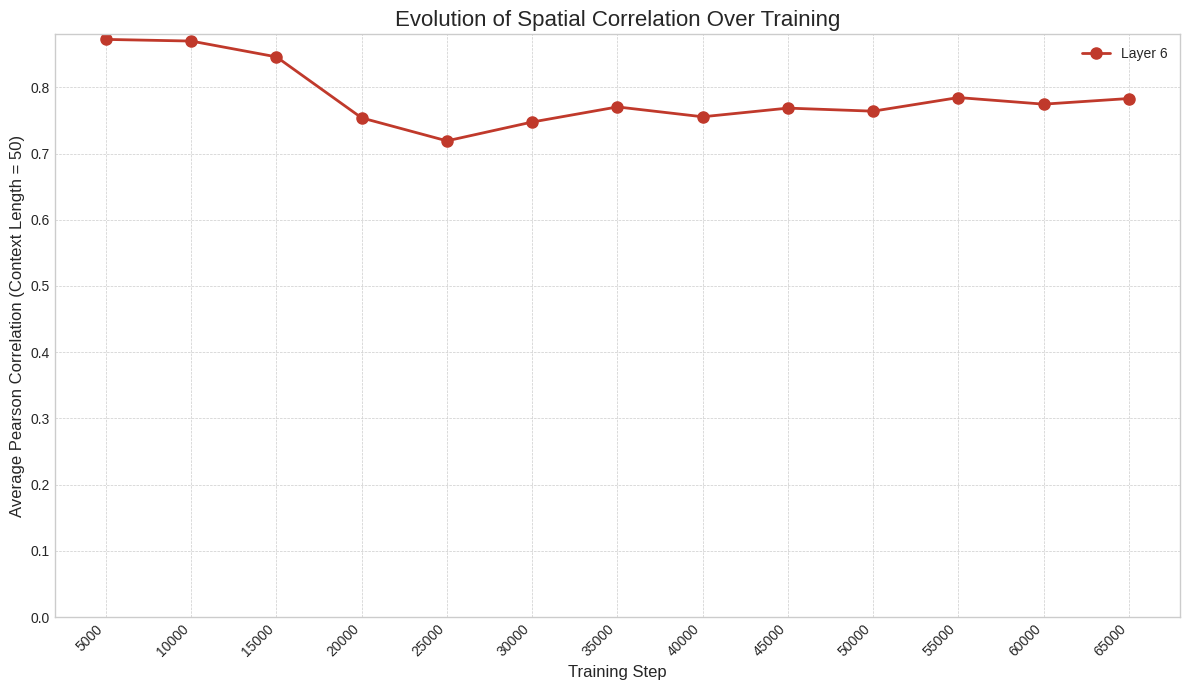

In [ ]:
import os
import logging
import random
import string
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from scipy.stats import pearsonr

# --- Basic Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- Experiment Parameters ---
CWD = os.getcwd()
MODEL_OUTPUT_DIR = 'generalist_model' # The directory containing the checkpoint folders
MODEL_BASE_PATH = os.path.join(CWD, MODEL_OUTPUT_DIR)
CHECKPOINT_STEPS = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6                # The specific layer we are analyzing
WALK_LENGTH = 50             # Fixed context length for a fair comparison across checkpoints
N_RUNS = 200                 # Number of trials to average for each checkpoint to get a stable score

# =========================================================================
# === PART 1: Data Generation Utilities (for creating test prompts) =======
# =========================================================================

def generate_name() -> str:
    """Generates a random 2-character lowercase string for a node name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def get_grid_graph_3x3():
    """Generates a standard 3x3 grid graph with unique random names."""
    nodes = [generate_name() for _ in range(9)]
    G = nx.DiGraph()
    size = 3
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx + 1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx - 1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx + size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx - size], direction='NORTH')
    return G, nodes

def build_positions_3x3(node_names):
    """Creates a dictionary mapping node names to (row, col) coordinates."""
    size = 3
    return {node_names[r*size + c]: (r, c) for r in range(size) for c in range(size)}

def generate_long_random_walk(G, walk_length):
    """Generates a single random walk with revisits."""
    nodes = list(G.nodes())
    start_node = random.choice(nodes)
    walk = [start_node]
    current_node = start_node
    for _ in range(walk_length - 1):
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk

def walk_to_string(walk, G):
    """Converts a list of nodes into the string format for the model."""
    path_body = ""
    for i in range(len(walk) - 1):
        node1, node2 = walk[i], walk[i+1]
        try:
            direction = G.edges[(node1, node2)]['direction']
            path_body += f"{node1} {direction} "
        except KeyError:
            return "" # Return empty if path is invalid
    path_body += walk[-1]
    return path_body

# =========================================================================
# === PART 2: The Model Wrapper and Metric Calculation ====================
# =========================================================================

class GPTLayerWrapper:
    """
    A wrapper to handle model and tokenizer loading from a self-contained
    checkpoint directory and to extract hidden states.
    """
    def __init__(self, checkpoint_path: str):
        logging.info(f"Loading model and tokenizer from: {checkpoint_path}")
        self.tokenizer = GPT2TokenizerFast.from_pretrained(checkpoint_path)
        self.model = GPT2LMHeadModel.from_pretrained(checkpoint_path, output_hidden_states=True).to(DEVICE)
        self.model.eval()

# --- Corrected get_node_embeddings_from_layer ---

    def get_node_embeddings_from_layer(self, prompt, node_names, layer):

        # Tokenize the full prompt
        encodings = self.tokenizer(prompt, return_tensors="pt").to(DEVICE) # Move everything to GPU at once
        input_ids_gpu = encodings.input_ids[0] # This tensor is now on the GPU

        # Get the hidden states for the prompt from the specified layer
        with torch.no_grad():
            outputs = self.model(**encodings)
            # The hidden_states are initially on the GPU
            hidden_states_gpu = outputs.hidden_states[layer].squeeze(0)

        loc_means = {}
        for node in node_names:
            # Tokenize the node name (this happens on the CPU)
            node_token_id = self.tokenizer.encode(' ' + node, add_special_tokens=False)
            
            if not node_token_id: continue
            node_token_id = node_token_id[0]

            # THE FIX: Perform the index-finding operation on the GPU
            # 'input_ids_gpu' is on GPU. The comparison creates a boolean tensor on GPU.
            # .nonzero() is called on the GPU tensor. 'indices' is now a tensor on the GPU.
            indices = (input_ids_gpu == node_token_id).nonzero(as_tuple=True)[0]
            
            if len(indices) > 0:
                # Index the GPU hidden_states tensor with the GPU indices tensor
                node_vectors = hidden_states_gpu[indices]
                
                # Perform the mean calculation on the GPU, then move the final result to CPU
                mean_vector = node_vectors.mean(dim=0).cpu().numpy()
                loc_means[node] = mean_vector
                
        return loc_means

def calc_pearson_correlation(node_names, loc_mean_repr, positions):
    """Calculates Pearson correlation between representational and grid distances."""
    recognized_nodes = [n for n in node_names if n in loc_mean_repr]
    if len(recognized_nodes) < 3:
        return float('nan')
        
    manhattan_distances = []
    representational_distances = []
    
    # Use combinations to get all unique pairs of nodes
    from itertools import combinations
    for u, v in combinations(recognized_nodes, 2):
        r1, c1 = positions[u]
        r2, c2 = positions[v]
        man_dist = abs(r1 - r2) + abs(c1 - c2)
        
        rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
        
        manhattan_distances.append(man_dist)
        representational_distances.append(rep_dist)
        
    if len(manhattan_distances) < 2:
        return float('nan')
        
    correlation, _ = pearsonr(manhattan_distances, representational_distances)
    return correlation

# =========================================================================
# === PART 3: Main Experiment Loop and Plotting ===========================
# =========================================================================

if __name__ == "__main__":
    logging.info("--- Starting Experiment: Spatial Correlation Over Training ---")

    correlations_over_training = []

    for step in CHECKPOINT_STEPS:
        checkpoint_path = os.path.join(MODEL_BASE_PATH, f"checkpoint-{step}")
        
        if not os.path.isdir(checkpoint_path):
            logging.warning(f"Checkpoint directory not found, skipping: {checkpoint_path}")
            correlations_over_training.append(float('nan'))
            continue

        try:
            wrapper = GPTLayerWrapper(checkpoint_path)
            
            run_corrs_for_checkpoint = []
            for i in range(N_RUNS):
                # Generate a new random grid and prompt for each run
                G, node_names = get_grid_graph_3x3()
                positions = build_positions_3x3(node_names)
                walk = generate_long_random_walk(G, walk_length=WALK_LENGTH)
                prompt = walk_to_string(walk, G)
                
                if not prompt: continue # Skip if walk generation failed

                # Analyze the model's representation
                loc_mean_repr = wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
                corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
                
                if not np.isnan(corr):
                    run_corrs_for_checkpoint.append(corr)
            
            mean_corr = np.mean(run_corrs_for_checkpoint) if run_corrs_for_checkpoint else float('nan')
            correlations_over_training.append(mean_corr)
            logging.info(f"Checkpoint {step}: Avg. Pearson Correlation = {mean_corr:.4f} (from {len(run_corrs_for_checkpoint)} runs)")
        
        except Exception as e:
            logging.error(f"An unexpected error occurred at checkpoint {step}: {e}")
            correlations_over_training.append(float('nan')) # Append NaN on error to maintain plot alignment
        
        finally:
            # Clean up memory
            del wrapper
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # --- Plotting the Results ---
    logging.info("--- Plotting Results ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    plt.plot(CHECKPOINT_STEPS, correlations_over_training, marker='o', linestyle='-', color='#c0392b', markersize=8, linewidth=2, label=f'Layer {LAYER_IDX}')

    plt.title('Evolution of Spatial Correlation Over Training', fontsize=16)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel(f'Average Pearson Correlation (Context Length = {WALK_LENGTH})', fontsize=12)
    
    # Ensure x-ticks are readable
    plt.xticks(rotation=45, ha="right")
    plt.gca().set_xticks(CHECKPOINT_STEPS) # Make sure all checkpoint steps are marked
    plt.ylim(bottom=0) # Correlation is usually positive, set y-axis minimum to 0

    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

2025-07-20 13:18:56,054 - INFO - --- Calculating Baseline: Untrained Model Performance ---
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
2025-07-20 13:19:03,816 - INFO - Baseline (Untrained Model): Avg. Pearson Correlation = 0.2650
2025-07-20 13:19:03,817 - INFO - --- Starting Experiment: Spatial Correlation Over Training ---
2025-07-20 13:19:03,817 - INFO - Loading model and tokenizer from: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/generalist_model/checkpoint-500
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more deta

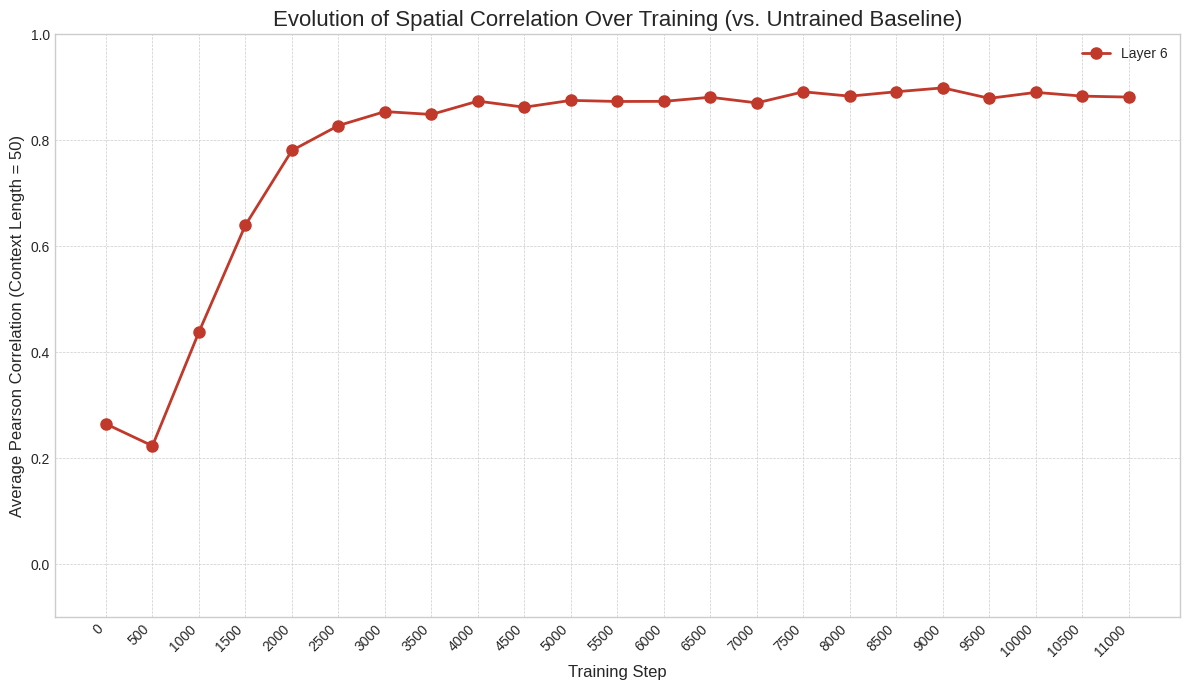

In [ ]:
import os
import logging
import random
import string
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoConfig # <-- Added AutoConfig
from scipy.stats import pearsonr

# --- Basic Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- Experiment Parameters ---
CWD = os.getcwd()
MODEL_OUTPUT_DIR = 'generalist_model'
MODEL_BASE_PATH = os.path.join(CWD, MODEL_OUTPUT_DIR)
CHECKPOINT_STEPS = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LAYER_IDX = 6
WALK_LENGTH = 50
N_RUNS = 200

# --- Data Generation Utilities (Unchanged) ---
# (Functions: generate_name, get_grid_graph_3x3, build_positions_3x3, generate_long_random_walk, walk_to_string)
def generate_name() -> str:
    return ''.join(random.choices(string.ascii_lowercase, k=2))
def get_grid_graph_3x3():
    nodes = [generate_name() for _ in range(9)]
    G = nx.DiGraph()
    size = 3
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            if c < size - 1: G.add_edge(nodes[idx], nodes[idx + 1], direction='EAST')
            if c > 0: G.add_edge(nodes[idx], nodes[idx - 1], direction='WEST')
            if r < size - 1: G.add_edge(nodes[idx], nodes[idx + size], direction='SOUTH')
            if r > 0: G.add_edge(nodes[idx], nodes[idx - size], direction='NORTH')
    return G, nodes
def build_positions_3x3(node_names):
    size = 3
    return {node_names[r*size + c]: (r, c) for r in range(size) for c in range(size)}
def generate_long_random_walk(G, walk_length):
    nodes = list(G.nodes())
    start_node = random.choice(nodes)
    walk = [start_node]
    current_node = start_node
    for _ in range(walk_length - 1):
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        next_node = random.choice(neighbors)
        walk.append(next_node)
        current_node = next_node
    return walk
def walk_to_string(walk, G):
    path_body = ""
    for i in range(len(walk) - 1):
        node1, node2 = walk[i], walk[i+1]
        try:
            direction = G.edges[(node1, node2)]['direction']
            path_body += f"{node1} {direction} "
        except KeyError: return ""
    path_body += walk[-1]
    return path_body

# =========================================================================
# === PART 2: The Model Wrapper and Metric Calculation ====================
# =========================================================================

# --- REFACTORED GPTLayerWrapper ---
class GPTLayerWrapper:
    """A flexible wrapper that can accept a pre-loaded model or load one from a path."""
    def __init__(self, model, tokenizer):
        self.model = model.to(DEVICE)
        self.tokenizer = tokenizer
        self.model.eval()

    @classmethod
    def from_checkpoint(cls, checkpoint_path: str):
        """Class method to load from a self-contained checkpoint directory."""
        logging.info(f"Loading model and tokenizer from: {checkpoint_path}")
        tokenizer = GPT2TokenizerFast.from_pretrained(checkpoint_path)
        model = GPT2LMHeadModel.from_pretrained(checkpoint_path, output_hidden_states=True)
        return cls(model, tokenizer)

    # --- (get_node_embeddings_from_layer and calc_pearson_correlation are unchanged) ---
    def get_node_embeddings_from_layer(self, prompt, node_names, layer):
        encodings = self.tokenizer(prompt, return_tensors="pt").to(DEVICE)
        input_ids_gpu = encodings.input_ids[0]
        with torch.no_grad():
            outputs = self.model(**encodings)
            hidden_states_gpu = outputs.hidden_states[layer].squeeze(0)
        loc_means = {}
        for node in node_names:
            node_token_id = self.tokenizer.encode(' ' + node, add_special_tokens=False)
            if not node_token_id: continue
            node_token_id = node_token_id[0]
            indices = (input_ids_gpu == node_token_id).nonzero(as_tuple=True)[0]
            if len(indices) > 0:
                node_vectors = hidden_states_gpu[indices]
                mean_vector = node_vectors.mean(dim=0).cpu().numpy()
                loc_means[node] = mean_vector
        return loc_means

def calc_pearson_correlation(node_names, loc_mean_repr, positions):
    recognized_nodes = [n for n in node_names if n in loc_mean_repr]
    if len(recognized_nodes) < 3: return float('nan')
    manhattan_distances, representational_distances = [], []
    from itertools import combinations
    for u, v in combinations(recognized_nodes, 2):
        r1, c1 = positions[u]; r2, c2 = positions[v]
        man_dist = abs(r1 - r2) + abs(c1 - c2)
        rep_dist = np.linalg.norm(loc_mean_repr[u] - loc_mean_repr[v])
        manhattan_distances.append(man_dist)
        representational_distances.append(rep_dist)
    if len(manhattan_distances) < 2: return float('nan')
    correlation, _ = pearsonr(manhattan_distances, representational_distances)
    return correlation

# =========================================================================
# === PART 3: Main Experiment Loop and Plotting ===========================
# =========================================================================

if __name__ == "__main__":
    
    # --- NEW: Calculate Baseline Performance (Step 0) ---
    logging.info("--- Calculating Baseline: Untrained Model Performance ---")
    
    # Use the final model's directory to get the correct config and tokenizer
    final_model_path = os.path.join(MODEL_BASE_PATH, f"checkpoint-{CHECKPOINT_STEPS[-1]}")
    if not os.path.isdir(final_model_path):
        raise FileNotFoundError(f"Final model path for config loading not found: {final_model_path}")

    # Load config and tokenizer
    config = AutoConfig.from_pretrained(final_model_path, output_hidden_states=True)
    tokenizer = GPT2TokenizerFast.from_pretrained(final_model_path)
    
    # Create a new model from the config (this initializes it with random weights)
    untrained_model = GPT2LMHeadModel(config)
    
    # Use the flexible wrapper
    baseline_wrapper = GPTLayerWrapper(untrained_model, tokenizer)

    baseline_corrs = []
    for i in range(N_RUNS):
        G, node_names = get_grid_graph_3x3()
        positions = build_positions_3x3(node_names)
        walk = generate_long_random_walk(G, walk_length=WALK_LENGTH)
        prompt = walk_to_string(walk, G)
        if not prompt: continue
        loc_mean_repr = baseline_wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
        corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
        if not np.isnan(corr):
            baseline_corrs.append(corr)
    
    baseline_mean_corr = np.mean(baseline_corrs) if baseline_corrs else float('nan')
    logging.info(f"Baseline (Untrained Model): Avg. Pearson Correlation = {baseline_mean_corr:.4f}")

    # --- Main Experiment: Spatial Correlation Over Training ---
    logging.info("--- Starting Experiment: Spatial Correlation Over Training ---")
    
    # Initialize lists with the baseline "step 0" result
    plot_steps = [0] + CHECKPOINT_STEPS
    correlations_over_training = [baseline_mean_corr]

    for step in CHECKPOINT_STEPS:
        checkpoint_path = os.path.join(MODEL_BASE_PATH, f"checkpoint-{step}")
        if not os.path.isdir(checkpoint_path):
            logging.warning(f"Checkpoint directory not found, skipping: {checkpoint_path}")
            correlations_over_training.append(float('nan'))
            continue

        try:
            wrapper = GPTLayerWrapper.from_checkpoint(checkpoint_path)
            run_corrs_for_checkpoint = []
            for i in range(N_RUNS):
                G, node_names = get_grid_graph_3x3()
                positions = build_positions_3x3(node_names)
                walk = generate_long_random_walk(G, walk_length=WALK_LENGTH)
                prompt = walk_to_string(walk, G)
                if not prompt: continue
                loc_mean_repr = wrapper.get_node_embeddings_from_layer(prompt, node_names, layer=LAYER_IDX)
                corr = calc_pearson_correlation(node_names, loc_mean_repr, positions)
                if not np.isnan(corr):
                    run_corrs_for_checkpoint.append(corr)
            mean_corr = np.mean(run_corrs_for_checkpoint) if run_corrs_for_checkpoint else float('nan')
            correlations_over_training.append(mean_corr)
            logging.info(f"Checkpoint {step}: Avg. Pearson Correlation = {mean_corr:.4f} (from {len(run_corrs_for_checkpoint)} runs)")
        
        except Exception as e:
            logging.error(f"An unexpected error at checkpoint {step}: {e}")
            correlations_over_training.append(float('nan'))
        
        # finally:
        #     del wrapper
        #     if 'baseline_wrapper' in locals(): del baseline_wrapper
        #     if torch.cuda.is_available(): torch.cuda.empty_cache()

    # --- Plotting the Results ---
    logging.info("--- Plotting Results ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    # Use the new lists that include the baseline
    plt.plot(plot_steps, correlations_over_training, marker='o', linestyle='-', color='#c0392b', markersize=8, linewidth=2, label=f'Layer {LAYER_IDX}')
    
    plt.title('Evolution of Spatial Correlation Over Training (vs. Untrained Baseline)', fontsize=16)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel(f'Average Pearson Correlation (Context Length = {WALK_LENGTH})', fontsize=12)
    
    plt.xticks(rotation=45, ha="right")
    plt.gca().set_xticks(plot_steps) # Use the new steps list for ticks
    plt.ylim(bottom=-0.1, top=1.0) # Allow for slightly negative correlation for random baseline

    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()